In [1]:
%matplotlib inline

import os
import itertools
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from math import sqrt

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import utils



from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

from scipy import signal



# Always make it pretty.
plt.style.use('ggplot')

# We get some interger -> float typecast warning from sklean below, this keeps them out of our hair.
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Data Preparation

In [2]:
d = pd.read_csv('data/normalized_temp_data_together.csv')
d.pop('Unnamed: 0')
def df_cleaner(df):
    df['DateTime'] = pd.to_datetime(df['DateTime'])
    return df
df = df_cleaner(d)
df = df.set_index(pd.DatetimeIndex(df.DateTime))
df.head()

,DateTime,Henry Hub Price $/MMBtu,Production MMCF,Storage BCFE,Reserves BCFE,Consumption MMCF,DOY,Temp
DateTime,,,,,,,,
2010-01-01,2010-01-01,5.82,2197157.0,3117.0,255035.0,1666520.0,1,33.150210
2010-01-02,2010-01-02,5.82,2197157.0,3117.0,255035.0,1666520.0,2,28.389823
2010-01-03,2010-01-03,5.82,2197157.0,3117.0,255035.0,1666520.0,3,26.753999
2010-01-04,2010-01-04,6.09,2197157.0,3117.0,255035.0,1666520.0,4,27.523758
2010-01-05,2010-01-05,6.19,2197157.0,3117.0,255035.0,1666520.0,5,28.425495


In [3]:
df['MOY'] =df['DateTime']
def moy(x):
    #test = df_shift_final['DateTime'][x]
    date = datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")
    return date.month
df['MOY'] = df['MOY'].apply(lambda x : moy(x))

df['WOY'] =df['DateTime']
def woy(x):
    #test = df_shift_final['DateTime'][x]
    date = datetime.datetime.strptime(str(x), "%Y-%m-%d %H:%M:%S")
    return int(date.strftime("%V"))
df['WOY'] = df['WOY'].apply(lambda x : woy(x))
#df.pop('DateTime')
dfw =df.resample('W').mean()
dfw['one_week_back_temp'] = dfw['Temp'].shift(1).fillna(method= 'backfill')
dfw['two_week_back_temp'] = dfw['Temp'].shift(2).fillna(method= 'backfill')
dfw['Consumption MMCF'] = dfw['Consumption MMCF'].apply(lambda x : x/1000)
dfw = dfw.rename(index=str, columns={"Consumption MMCF": "Consumption BCF"})
temp = dfw.reset_index()
dfww = temp.set_index(pd.DatetimeIndex(temp.DateTime))
dfww.pop('DateTime')
matrix = ['Consumption BCF', 'Temp', 'Production MMCF', 'Storage BCFE',
       'MOY', 'WOY']
dff = dfww[matrix]

dff.head()

,Consumption BCF,Temp,Production MMCF,Storage BCFE,MOY,WOY
DateTime,,,,,,
2010-01-03,1666.520000,29.431344,2.197157e+06,3117.000000,1.0,53.0
2010-01-10,1666.520000,27.893440,2.197157e+06,3117.000000,1.0,1.0
2010-01-17,1666.520000,37.288026,2.197157e+06,2964.428571,1.0,2.0
2010-01-24,1666.520000,40.823888,2.197157e+06,2711.142857,1.0,3.0
2010-01-31,1713.513286,33.289143,2.174443e+06,2557.857143,1.0,4.0


In [4]:
def plot_trend_data(ax, column_name, df):
    ax.plot(df.index, df[column_name])
    ax.set_title("Ten years trend of {}".format(column_name))

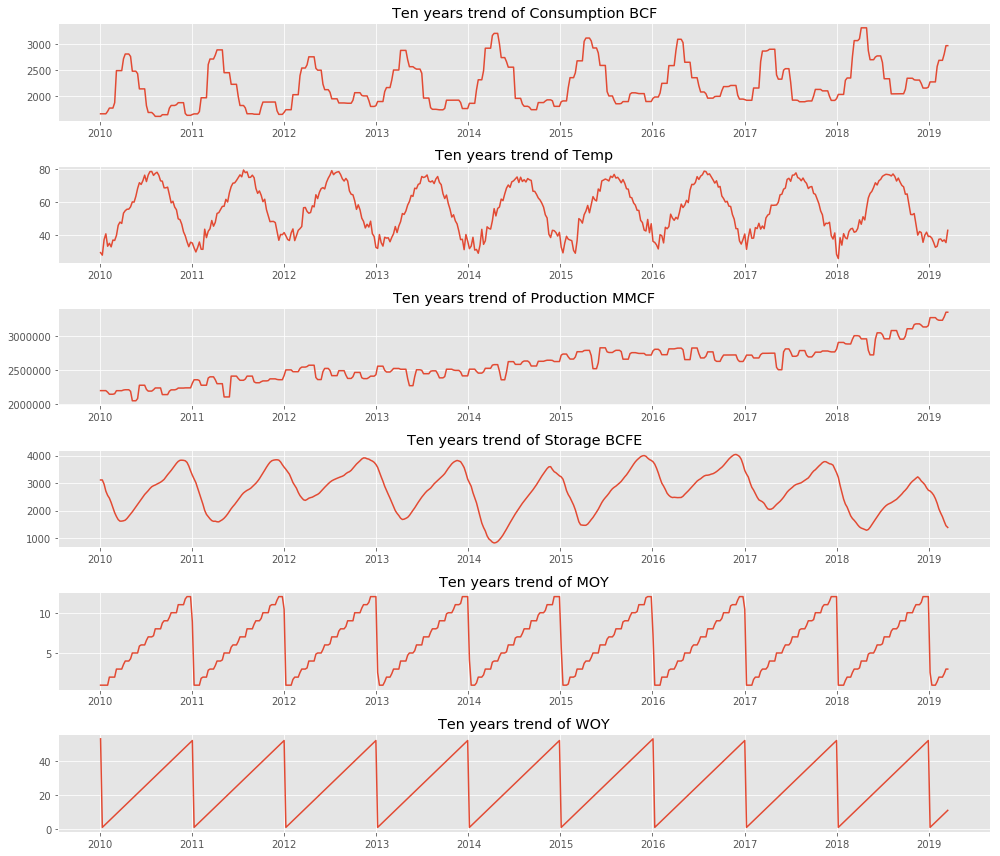

In [5]:
fig, axs = plt.subplots(len(matrix), figsize=(14, 12))
 
for ax, column_name in zip(axs, matrix):
    plot_trend_data(ax, column_name, dff)
    
plt.tight_layout()

#### Some observations:

- the `price` plot shows a more random pattern than the others. it has a non-linear trend over time with some seasonal behaviour.
- The `temperature` plot shows very strong oscillations aligned with seasonality in the northern hemisphere. 
- The `production` plot shows a general increase over time, probably influenced by the increase in shale plays production efficiencies.
- The `storage` plot shows very strong oscillations aligned with seasonality in the northern hemisphere. In general, storage levels decrease during the winter and increase during the summer.
- The `reserves` plot shows a general increase over time, probably influenced by the increase in shale plays discoveries in the last few years.
- The `consumption` plot shows very strong oscillations aligned with seasonality in the northern hemisphere. In general, natural gas consumption levels increase during the winter and decrease during the summer.

In [6]:
def plot_trend_data(ax, name, series):
    ax.plot(series.index, series)
    ax.set_title(" Trend For {}".format(name))

def fit_moving_average_trend(series, window=365):
    return series.rolling(window, center=True).mean()

def plot_moving_average_trend(ax, name, series, window=52):
    moving_average_trend = fit_moving_average_trend(series, window)
    plot_trend_data(ax, name, series)
    ax.plot(series.index, moving_average_trend)


## Trend-Seasonal-Residual Decomposition

The Classical Trend-Seasonal-Residual Decomposition expresses a time series as the sum of three components:

$$ y_t = T_t + S_t + R_t $$


In [7]:
def plot_seasonal_decomposition(axs, series, sd):
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series")
    axs[1].plot(series.index, sd.trend)
    axs[1].set_title("Trend Component $T_t$")
    axs[2].plot(series.index, sd.seasonal)
    axs[2].set_title("Seasonal Component $S_t$")
    axs[3].plot(series.index, sd.resid)
    axs[3].set_title("Residual Component $R_t$")

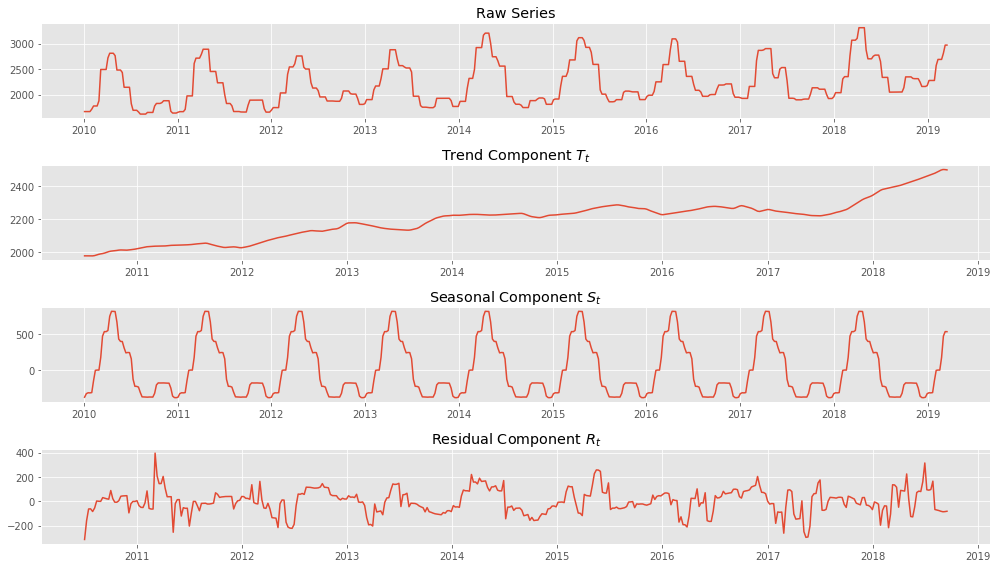

In [8]:
consumption_decomposition = sm.tsa.seasonal_decompose(dff['Consumption BCF'], freq= 52)

fig, axs = plt.subplots(4, figsize=(14, 8))
plot_seasonal_decomposition(axs, dff['Consumption BCF'], consumption_decomposition)
plt.tight_layout()

### Sharp increase in queries around wintertime, dropoff for queries around spring and fall, and slide increase for queries around summer.

# Stationary Analysis

In [9]:
def plot_series_and_difference(axs, series, title):
    diff = series.diff()
    axs[0].plot(series.index, series)
    axs[0].set_title("Raw Series: {}".format(title))
    axs[1].plot(series.index, diff)
    axs[1].set_title("Series of First Differences: {}".format(title))

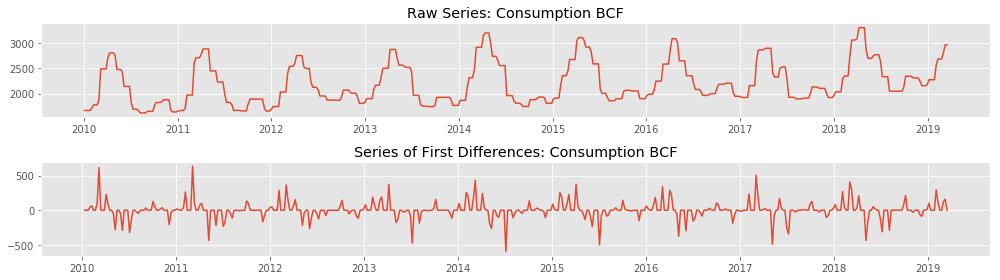

In [10]:
fig, axs = plt.subplots(2, figsize=(14, 4))
plot_series_and_difference(axs, dff['Consumption BCF'], 'Consumption BCF')
fig.tight_layout()

In [11]:
test = sm.tsa.stattools.adfuller(dff['Consumption BCF'])
print("ADF p-value for python series: {0:2.2f}".format(test[1]))

ADF p-value for python series: 0.00


In [12]:
Consumption_differences =dff['Consumption BCF'].diff()[1:]
test = sm.tsa.stattools.adfuller(Consumption_differences)
print("ADF p-value for differenced python series: {0:2.2f}".format(test[1]))

ADF p-value for differenced python series: 0.00


In [13]:
def series_and_lagged(series, lag=1):
    truncated = np.copy(series)[lag:]
    lagged = np.copy(series)[:(len(truncated))]
    return truncated, lagged

def compute_autocorrelation(series, lag=1):
    series, lagged = series_and_lagged(series, lag=lag)
    return np.corrcoef(series, lagged)[0, 1]

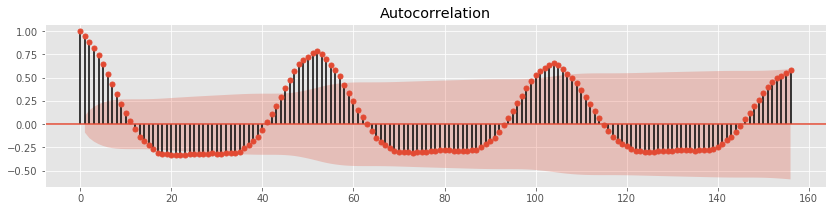

In [14]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(dff['Consumption BCF'], lags=3*52, ax=ax)
#ax.set_ylim([-.1, .1])

- There is a very striking spike at exactly 52 lags, which is the number of weeks in a year. This is repeated, less significantly, at a lag of twice 52.

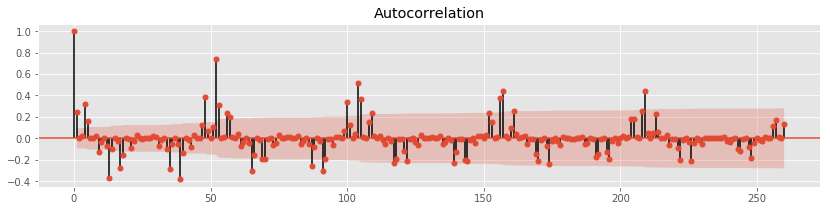

In [15]:
fig, ax = plt.subplots(1, figsize=(14, 3))
_ = sm.graphics.tsa.plot_acf(Consumption_differences, lags=5*52, ax=ax)
#ax.set_ylim([-.1, .1])

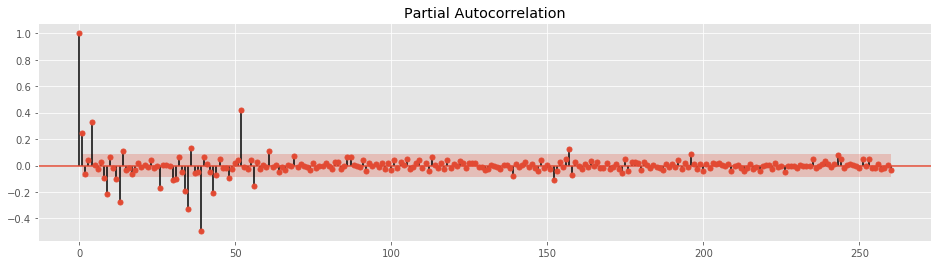

In [16]:
fig, ax = plt.subplots(1, figsize=(16, 4))

_ = sm.graphics.tsa.plot_pacf(Consumption_differences, lags=5*52, ax=ax, method='ywmle')

The parameters of the ARIMA model are defined as follows:

p: The number of lag observations included in the model, also called the lag order. 1

d: The number of times that the raw observations are differenced, also called the degree of differencing. 1

q: The size of the moving average window, also called the order of moving average. 1

sp: 1

sd: 0 

sq: 1

In [17]:
X = dff['Consumption BCF']
size = int(len(X) * 0.75)
train, test = X[0:size], X[size:len(X)]
model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 0, 1, 52)).fit()

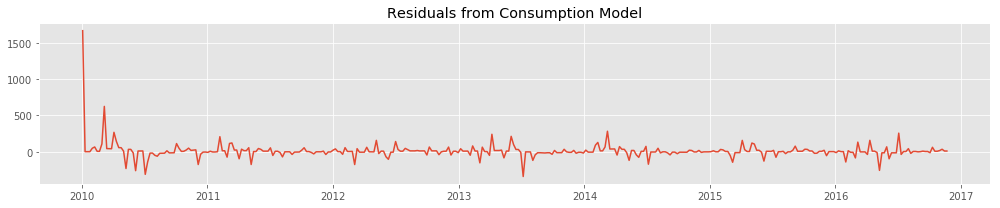

In [18]:
fig, ax = plt.subplots(1, figsize=(14, 3))
ax.plot(model.resid.index, model.resid)
ax.set_title("Residuals from Consumption Model")
plt.tight_layout()

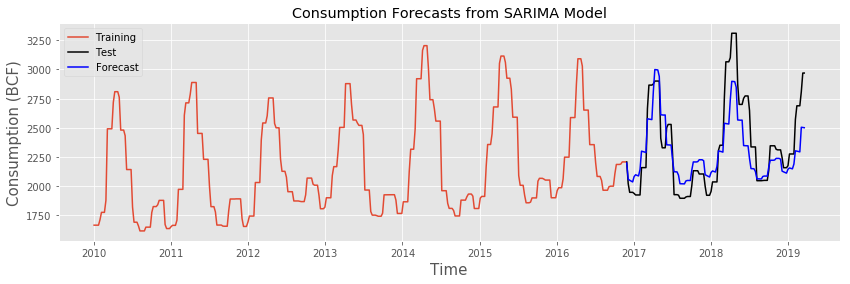

In [19]:
fig, ax = plt.subplots(1, figsize=(14, 4))
ax.plot(train.index, train, label= 'Training')
ax.plot(test, label= 'Test', color='black')
preds = model.predict('2016-11-27', '2019-03-17', dynamic=True, ax=ax, plot_insample=False)

ax.plot(preds.index, preds, label= 'Forecast', color='blue')

_ = ax.legend().get_texts()[1].set_text("95% Prediction Interval")
#_ = ax.legend(loc="lower left")

_ = ax.set_title("Consumption Forecasts from SARIMA Model")
#ax.set_xlim([0, 40])
#ax.set_ylim([2.4, 3.5])
ax.set_ylabel("Consumption (BCF)", fontsize = 15)
ax.set_xlabel("Time", fontsize = 15)
ax.legend()

In [20]:
error = sqrt(mean_squared_error(test, preds))
print('Test RMSE: %.2f' % error)

Test RMSE: 216.00


In [21]:
error = r2_score(test, preds)
print('Test R^2: %.2f' % error)

Test R^2: 0.69


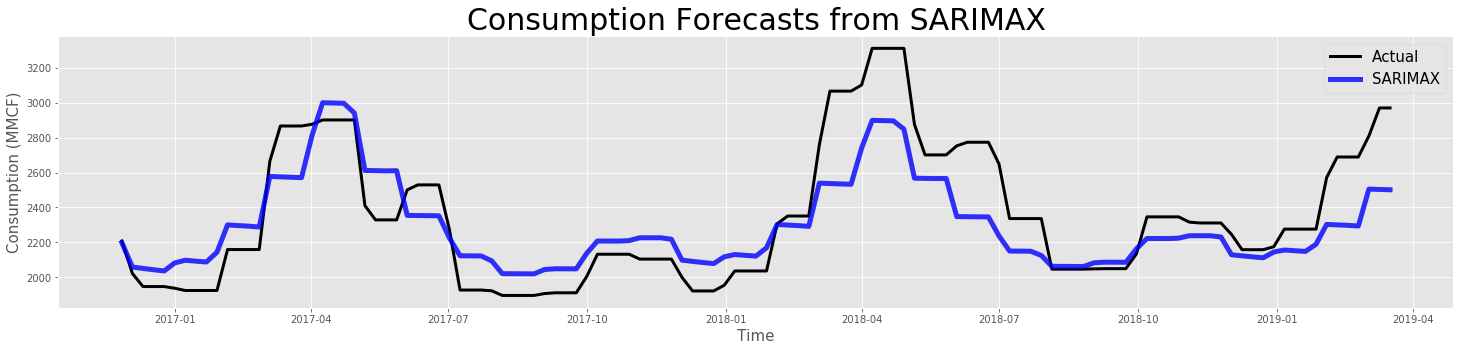

In [22]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(test, color='black', label = 'Actual', linewidth=3)
axs.plot(preds, color='blue', alpha = 0.8, label = 'SARIMAX', linewidth=5)
axs.set_title("Consumption Forecasts from SARIMAX", fontsize = 30)
axs.set_ylabel("Consumption (MMCF)", fontsize = 15)
axs.set_xlabel("Time", fontsize = 15)
axs.legend(fontsize = 15)
#axs.set_xlim([300, 600])
#axs.set_ylim([-0.2, .2])
plt.show()

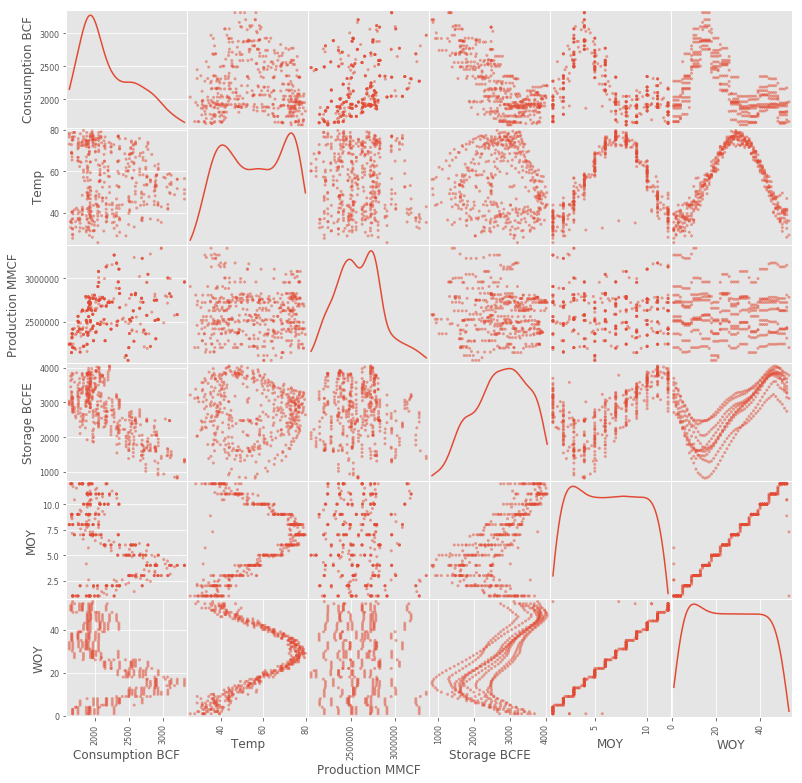

In [23]:
from pandas.plotting import scatter_matrix
fig, ax = plt.subplots(1, 1, figsize=(13, 13))
ax = scatter_matrix(dff[matrix], ax=ax, diagonal='kde')

In [24]:
y = dff.pop('Consumption BCF')
X = dff

In [25]:
size = int(len(X) * 0.75)
X_train, X_test, y_train, y_test = X.values[0:size], X.values[size:len(X)], y.values[0:size], y.values[size:len(y)]

In [26]:
X_train, X_test, y_train, y_test 
history_X = X_train
history_y = y_train
predictions = list()
rfr = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=90,
           max_features=2, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=4,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=500, n_jobs=None, oob_score=False,
           random_state=None, verbose=0, warm_start=False)
rfr_fit = rfr.fit(X_train, y_train)
for t in range(len(y_test)):
    output = rfr_fit.predict(X_test[t].reshape((1,5)))
    yhat = output[0]
    predictions.append(yhat)
#     obs = y_test[t]
#     history_X = np.append(history_X, X_test[t].reshape((1,6)), axis=0)
#     history_y = np.append(history_y,obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(y_test), yhat, obs))

error = sqrt(mean_squared_error(y_test, predictions))
print('Test RMSE: %.5f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test RMSE: 209.87304


In [27]:
error = r2_score(y_test, predictions)
print('Test R^2: %.2f' % error)

Test R^2: 0.70


In [28]:
RF_preds = pd.Series(predictions)
df_pred = pd.DataFrame(preds, columns= ['SARIMAX'])
df_pred = df_pred.reset_index()
df_pred['RF'] = RF_preds

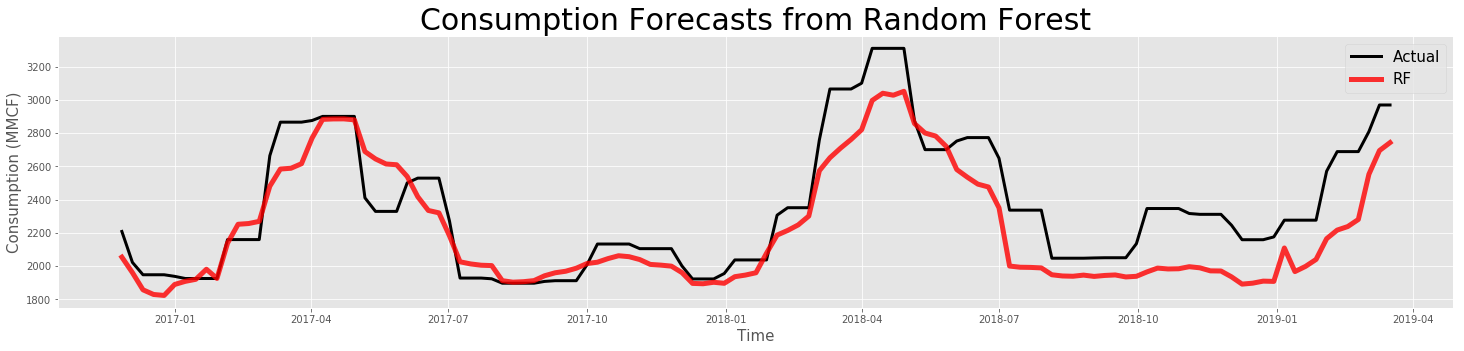

In [29]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(test, color='black', label = 'Actual', linewidth=3)
axs.plot(df_pred['index'], df_pred['RF'], color='red', alpha = 0.8, label = 'RF', linewidth=5)
#axs.plot(df_pred['index'], df_pred['SARIMAX'], color='red', alpha = 0.8, label = 'SARIMAX', linewidth=5)
axs.set_title("Consumption Forecasts from Random Forest", fontsize = 30)
axs.set_ylabel("Consumption (MMCF)", fontsize = 15)
axs.set_xlabel("Time", fontsize = 15)
axs.legend(fontsize = 15)
#axs.set_xlim([300, 600])
#axs.set_ylim([-0.2, .2])
plt.show()

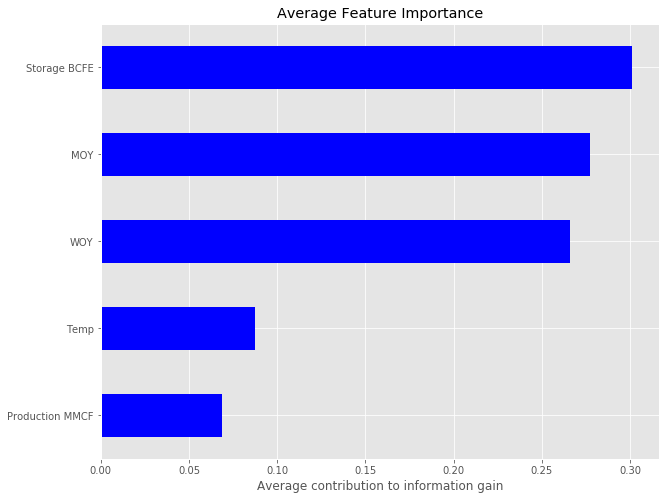

In [30]:
# Plot the feature importance
feat_scores = pd.Series(rfr.feature_importances_,
                           index=dff.columns)
feat_scores = feat_scores.sort_values()
ax = feat_scores.plot(kind='barh', 
                      figsize=(10,8),
                      color='b')
ax.set_title('Average Feature Importance')
ax.set_xlabel('Average contribution to information gain');

In [31]:
X_train, X_test, y_train, y_test 
history_X = X_train
history_y = y_train
predictions2 = list()
grd = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.001, loss='ls', max_depth=5,
             max_leaf_nodes=2, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=15,
             min_samples_split=15, min_weight_fraction_leaf=0.0,
             n_estimators=5000, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)
grd_fit = rfr.fit(X_train, y_train)
for t in range(len(y_test)):
    output = grd_fit.predict(X_test[t].reshape((1,5)))
    yhat = output[0]
    predictions2.append(yhat)
#     obs = y_test[t]
#     history_X = np.append(history_X, X_test[t].reshape((1,6)), axis=0)
#     history_y = np.append(history_y,obs)
    #print('{} of {} predicted={}, expected={}'.format(t, len(y_test), yhat, obs))

error = sqrt(mean_squared_error(y_test, predictions2))
print('Test RMSE: %.2f' % error)

# plt.plot(test)
# plt.plot(predictions, color='red')
# plt.show()

Test RMSE: 208.82


In [32]:
error = r2_score(y_test, predictions2)
print('Test R^2: %.2f' % error)

Test R^2: 0.71


In [33]:
GB_preds = pd.Series(predictions2)
df_pred['GB'] = GB_preds

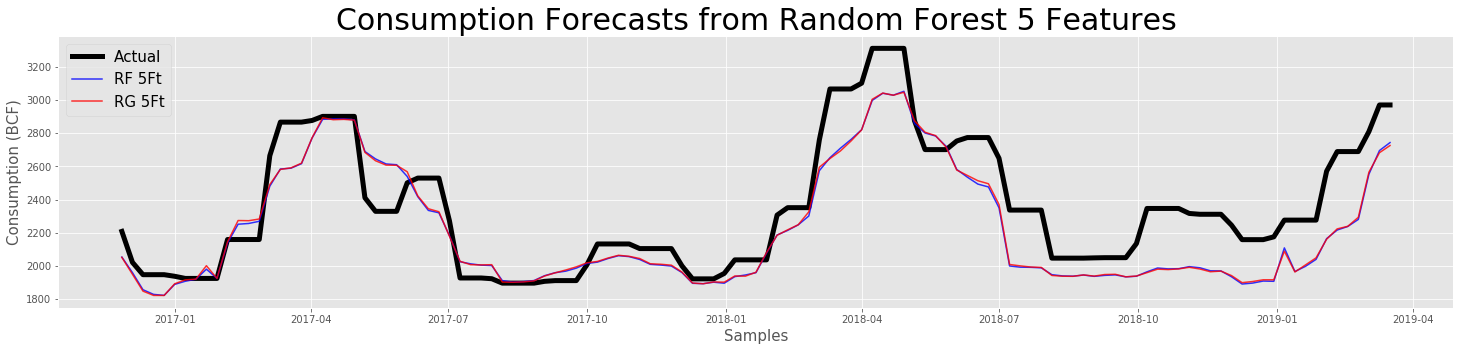

In [34]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(test, color='black', label = 'Actual', linewidth=5)
axs.plot(df_pred['index'], df_pred['RF'], color='blue', alpha = 0.8, label = 'RF 5Ft')
axs.plot(df_pred['index'], df_pred['GB'], color='red', alpha = 0.8, label = 'RG 5Ft')
#axs.plot(df_pred['index'], df_pred['SARIMAX'], color='red', alpha = 0.8, label = 'SARIMAX', linewidth=5)
axs.set_title("Consumption Forecasts from Random Forest 5 Features", fontsize = 30)
axs.set_ylabel("Consumption (BCF)", fontsize = 15)
axs.set_xlabel("Samples", fontsize = 15)
axs.legend(fontsize = 15)
#axs.set_xlim([300, 600])
#axs.set_ylim([-0.2, .2])
plt.show()

No handles with labels found to put in legend.


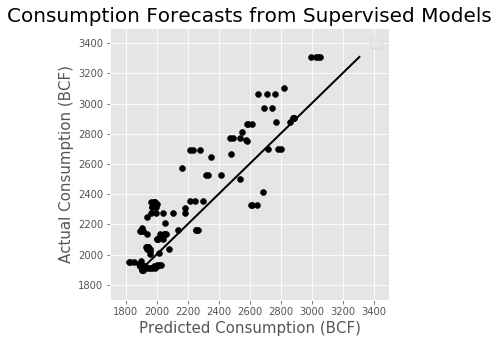

In [35]:
fig, axs = plt.subplots(figsize=(5, 5))
axs.scatter(predictions,y_test, color='black')

axs.plot([min(y_test), max(y_test)-2], 
          [min(y_test), max(y_test) -2], 'k', lw=2)

axs.set_xlim([1700, 3500])
axs.set_ylim([1700, 3500])
axs.set_title("Consumption Forecasts from Supervised Models", fontsize = 20)
axs.set_ylabel("Actual Consumption (BCF)", fontsize = 15)
axs.set_xlabel("Predicted Consumption (BCF)", fontsize = 15)
axs.legend(fontsize = 15)
plt.show()

# Recurrent Neural Network (RNN)

In [36]:
dfrnn = dfww[matrix]

In [37]:
dfrnn.columns

Index(['Consumption BCF', 'Temp', 'Production MMCF', 'Storage BCFE', 'MOY',
       'WOY'],
      dtype='object')

In [38]:
 # convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -52):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [39]:
values = dfrnn.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 52, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())
 


    var1(t-52)  var2(t-52)  var3(t-52)  var4(t-52)  var5(t-52)  var6(t-52)  \
52    0.029086    0.067357    0.114548    0.711548         0.0    1.000000   
53    0.029086    0.038741    0.114548    0.711548         0.0    0.000000   
54    0.029086    0.213548    0.114548    0.664168         0.0    0.019231   
55    0.029086    0.279341    0.114548    0.585511         0.0    0.038462   
56    0.056841    0.139140    0.097126    0.537909         0.0    0.057692   

     var1(t)  
52  0.021204  
53  0.028151  
54  0.028151  
55  0.028151  
56  0.054169  


In [40]:
# split into train and test sets
values = reframed.values
n_train_weeks = 308

train = values[:n_train_weeks, :]
test2 = values[n_train_weeks:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test2[:, :-1], test2[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(308, 1, 6) (308,) (121, 1, 6) (121,)


In [41]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 308 samples, validate on 121 samples
Epoch 1/50
 - 1s - loss: 0.3724 - val_loss: 0.4387
Epoch 2/50
 - 0s - loss: 0.3202 - val_loss: 0.3823
Epoch 3/50
 - 0s - loss: 0.2697 - val_loss: 0.3271
Epoch 4/50
 - 0s - loss: 0.2290 - val_loss: 0.2746
Epoch 5/50
 - 0s - loss: 0.2026 - val_loss: 0.2410
Epoch 6/50
 - 0s - loss: 0.1947 - val_loss: 0.2204
Epoch 7/50
 - 0s - loss: 0.1924 - val_loss: 0.2107
Epoch 8/50
 - 0s - loss: 0.1911 - val_loss: 0.2058
Epoch 9/50
 - 0s - loss: 0.1883 - val_loss: 0.2027
Epoch 10/50
 - 0s - loss: 0.1840 - val_loss: 0.2007
Epoch 11/50
 - 0s - loss: 0.1793 - val_loss: 0.1996
Epoch 12/50
 - 0s - loss: 0.1751 - val_loss: 0.1981
Epoch 13/50
 - 0s - loss: 0.1710 - val_loss: 0.1953
Epoch 14/50
 - 0s - loss: 0.1669 - val_loss: 0.1913
Epoch 15/50
 - 0s - loss: 0.1626 - val_loss: 0.1865
Epoch 16/50
 - 0s - loss: 0.1581 - val_loss: 0.1813
Epoch 17/50
 - 0s - loss: 0.1537 - val_loss: 0.1767
Epoch 18/50
 - 0s - loss: 0.1492 - val_loss: 0.1729
Epoch 19/50
 - 0s - loss: 0

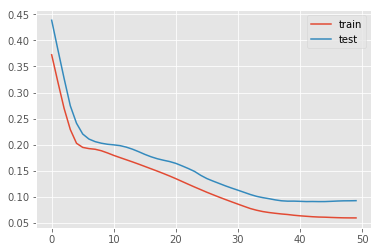

In [42]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()
 

In [43]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

In [44]:
# calculate RMSE
mse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test MSE: %.3f' % mse)

Test MSE: 190.316


In [49]:
error = r2_score(inv_y, inv_yhat)
print('Test R^2: %.2f' % error)

Test R^2: 0.76


In [46]:
LSTM_preds = pd.Series(inv_yhat)
df_pred['LSTM'] = LSTM_preds

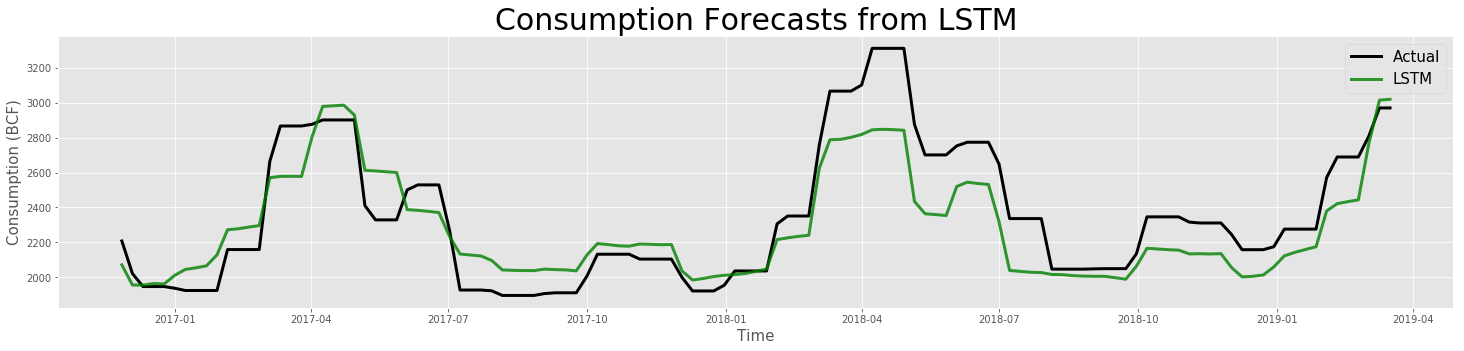

In [47]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(test, color='black', label = 'Actual', linewidth=3)
axs.plot(df_pred['index'], df_pred['LSTM'], color='green', alpha = 0.8, label = 'LSTM',linewidth=3)
axs.set_title("Consumption Forecasts from LSTM", fontsize = 30)
axs.set_ylabel("Consumption (BCF)", fontsize = 15)
axs.set_xlabel("Time", fontsize = 15)
axs.legend(fontsize = 15)
#axs.set_xlim([300, 600])
#axs.set_ylim([-0.2, .2])
plt.show()

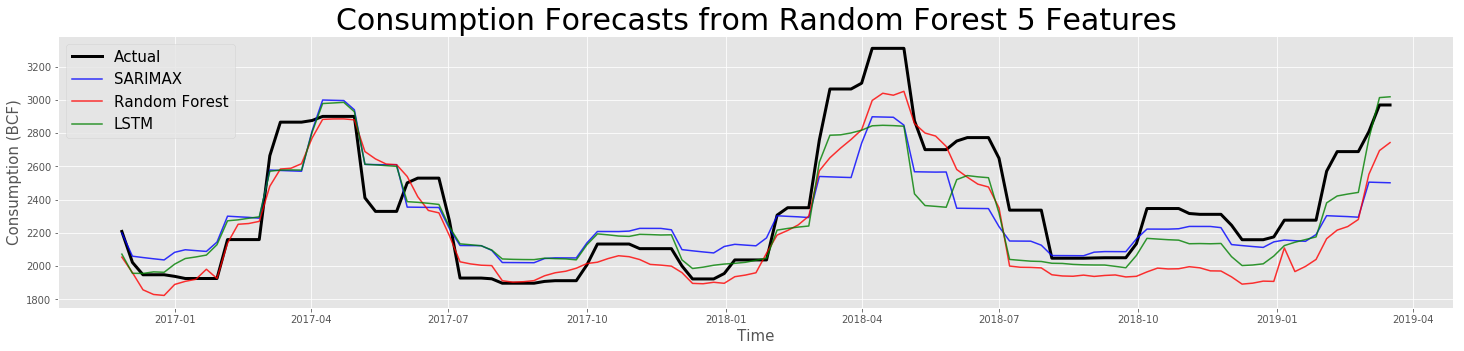

In [48]:
fig, axs = plt.subplots(figsize=(25, 5))
axs.plot(test, color='black', label = 'Actual', linewidth=3)
axs.plot(df_pred['index'], df_pred['SARIMAX'], color='blue', alpha = 0.8, label = 'SARIMAX')
axs.plot(df_pred['index'], df_pred['RF'], color='red', alpha = 0.8, label = 'Random Forest')
axs.plot(df_pred['index'], df_pred['LSTM'], color='green', alpha = 0.8, label = 'LSTM')
#axs.plot(df_pred['index'], df_pred['SARIMAX'], color='red', alpha = 0.8, label = 'SARIMAX', linewidth=5)
axs.set_title("Consumption Forecasts from Random Forest 5 Features", fontsize = 30)
axs.set_ylabel("Consumption (BCF)", fontsize = 15)
axs.set_xlabel("Time", fontsize = 15)
axs.legend(fontsize = 15)
#axs.set_xlim([300, 600])
#axs.set_ylim([-0.2, .2])
plt.show()